<a href="https://colab.research.google.com/github/Mr-MaNia7/deep-learning/blob/main/Fast_Food_Classification_in_DL_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Individual Assignment

### BY: Abdulkarim Getachew UGR/7992/12

*February 02, 2024*


## Import necessary libraries




In [1]:
import os
import sys
import shutil
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import numpy as np
import pandas as pd

import os

## Import Dataset -  *Fast Food Classification Dataset - V2 | 20k Images*

In [2]:
CHUNK_SIZE = 40960
DATA_SOURCES = 'fast-food-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2631527%2F4500698%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240203%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240203T064458Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db49e34181b85f56c7cb872b94330ff84c040343412ef2230eba1acc00b096e8ca6dec46062dd564511118c5472b22dca0a58425cbb60ff35a4b14fbcd50a498caa4f4f102428221b4a8b05ec02e6392b8bff89976092c6e7d5656d72c0beac2bb5e0402dc0c1f30ba673bd7893a554017f7221f6470ebb22800a538c3c58c20990ecd6901e3bdcc3a362dc7b8f1cf623e84871ec015e3d8fc77286ac891d48768724c789495b56c64a3ac22cad52774cc49585111dd08b8cff80d4066441fa46788f55007e94ebca5ae31885201e5a484e9bb61e11464e5386d52f3979ed8fdbdf3b5924201d0e98962ab1ed3b5c599e18facfe901433962afbe1824fe2fe63f'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# Clean existing directories
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symlinks
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Download and extract data sources
for data_source in DATA_SOURCES.split(','):
    directory, download_url_encoded = data_source.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as file_res, NamedTemporaryFile() as temp_file:
            total_length = file_res.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = file_res.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                temp_file.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = file_res.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(temp_file) as zip_file:
                    zip_file.extractall(destination_path)
            else:
                with tarfile.open(temp_file.name) as tar_file:
                    tar_file.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 472974480 bytes downloaded
Downloaded and uncompressed: fast-food-classification-dataset
Data source import complete.


In [3]:
for directory, _, files in os.walk('/kaggle/input'):
    for file in files:
        print(os.path.join(directory, file))

Streaming output truncated to the last 5000 lines.
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/6671_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/673_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/6941_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/3752_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/3909_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/5273_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/1940_Image.tfrecord
/kaggle/input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/1949_Image.tfrecord
/kaggle/input/fast-food-classification-dataset

## Install and Import PyTorch Libraries

In [4]:
!pip install torchinfo

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import re, os, sys, json, cv2, random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

## Read and Split Fast Food Classification Dataset


Sandwich               : 100%|████████████████████████████████████████| 1500/1500 [00:01<00:00, 1352.26file/s]


5 kinds of images were found in the dataset
7500 images were found in the dataset.
5977 for training, 1495 for validation
Average image height: 202   Average image width: 234  Aspect ratio h/w: 0.8632478632478633


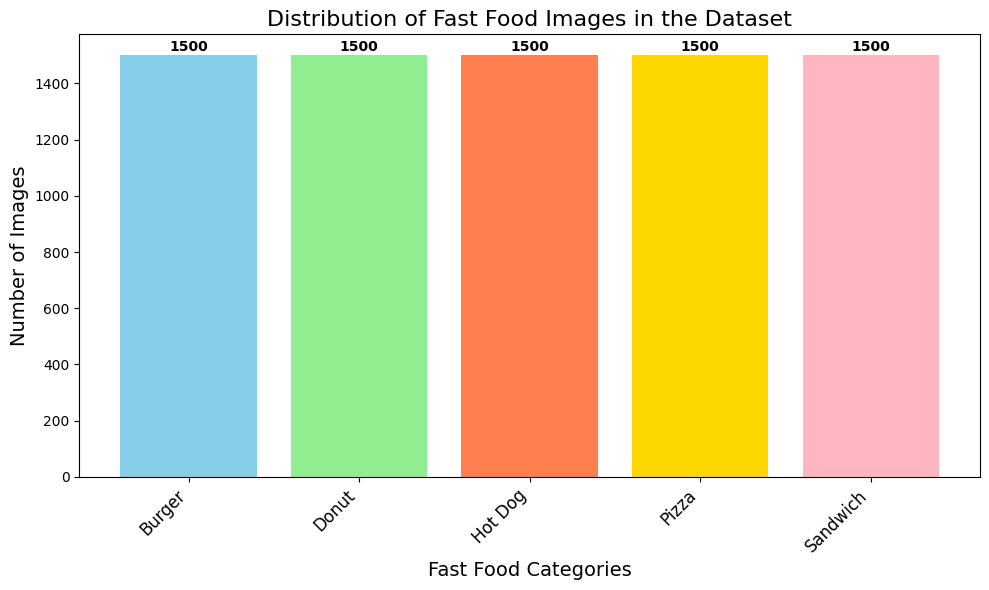

In [7]:
root = '/kaggle/input/fast-food-classification-dataset/Fast Food Data/Training Data/'

def read_split_data(root, plot_image=False):
    # Initialize lists to store filepaths, labels, and defective images
    filepaths = []
    labels = []
    bad_images = []

    # Ensure the specified root path exists
    assert os.path.exists(root), f'The specified path {root} does not exist!'

    # Get the list of classes (subdirectories) in the root directory
    classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    classes.sort()

    # Create class indices mapping and save it to a JSON file
    class_indices = {k: v for v, k in enumerate(classes)}
    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # Initialize a list to store the number of images for each class
    every_class_num = []

    # Supported image file extensions
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

    # Loop through each class
    for klass in classes:
        classpath = os.path.join(root, klass)

        # Get the list of image files in the class directory
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
        every_class_num.append(len(images))

        # Sort the list of images for consistency
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'

        # Iterate through each image in the class
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index:]

            # Check if the file extension is supported
            if ext in supported:
                image = Image.open(fpath)

                # Check if the image mode is RGB
                if image.mode == 'RGB':
                    try:
                        img = cv2.imread(fpath)
                        filepaths.append(fpath)
                        labels.append(klass)
                    except:
                        bad_images.append(fpath)
                        print('Defective image file:', fpath)
            else:
                bad_images.append(fpath)

    # Create Pandas Series for filepaths and labels, then concatenate them into a DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    # Print the number of unique classes found in the dataset
    print(f'{len(df.labels.unique())} kinds of images were found in the dataset')

    # Split the dataset into training and validation sets
    train_df, test_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

    # Extract image paths and labels for training and validation sets
    train_image_path = train_df['filepaths'].tolist()
    val_image_path = test_df['filepaths'].tolist()
    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
    val_image_label = [class_indices[i] for i in test_df['labels'].tolist()]

    # Sample 50 images for analysis
    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0

    # Calculate average image height, width, and aspect ratio
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h, w = img.shape[0], img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass

    average_height = int(ht / count)
    average_width = int(wt / count)
    aspect_ratio = average_height / average_width

    # Print dataset statistics
    print(f'{sum(every_class_num)} images were found in the dataset.')
    print(f'{len(train_image_path)} for training, {len(val_image_path)} for validation')
    print('Average image height:', average_height, '  Average image width:', average_width, ' Aspect ratio h/w:', aspect_ratio)


    # Plot class distribution if specified
    if plot_image:
        plt.figure(figsize=(10, 6))  # Adjust the figure size for better visualization

        # Create a colorful bar chart with annotations
        plt.bar(range(len(classes)), every_class_num, color=['skyblue', 'lightgreen', 'coral', 'gold', 'lightpink'], align='center')

        # Customize the appearance of the plot
        plt.title('Distribution of Fast Food Images in the Dataset', fontsize=16)
        plt.xlabel('Fast Food Categories', fontsize=14)
        plt.ylabel('Number of Images', fontsize=14)
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right', fontsize=12)

        # Annotate each bar with the respective number of images
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()


    return train_image_path, train_image_label, val_image_path, val_image_label, class_indices

# Driver Code
train_image_path, train_image_label, val_image_path, val_image_label, class_indices = read_split_data(root, plot_image=True)


## Custom Dataset Class


In [8]:
class MyDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        """
        Custom dataset for Fast Food Classification.

        Args:
            image_paths (list): List of filepaths to the images.
            image_labels (list): List of corresponding class labels.
            transform (callable, optional): Optional transform to be applied on each image.
        """
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding label.
        """
        image = Image.open(self.image_paths[idx])

        # Ensure the image is in RGB mode
        if image.mode != 'RGB':
            raise ValueError(f"Image {self.image_paths[idx]} is not an RGB image!")

        label = self.image_labels[idx]

        # Apply transformations if available
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    @staticmethod
    def collate_fn(batch):
        """
        Collate function to be used with DataLoader.

        Args:
            batch (list): List of samples, where each sample is a tuple of image and label.

        Returns:
            tuple: A tuple containing a batch of images and their corresponding labels.
        """
        images, labels = zip(*batch)
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

## Device Preprocessing


### Device Specification

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Transformation

In [10]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(200),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(200),
        transforms.CenterCrop(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Print the dataset split information
print("Data Transformations:")
print("Train Transformations:")
print(data_transform['train'])
print("\nValidation Transformations:")
print(data_transform['valid'])

print("\nDataset Split Information:")
print(f"Training Set Size: {len(train_image_path)} images")
print(f"Validation Set Size: {len(val_image_path)} images")

Data Transformations:
Train Transformations:
Compose(
    RandomResizedCrop(size=(200, 200), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    ToTensor()
    RandomHorizontalFlip(p=0.5)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Validation Transformations:
Compose(
    Resize(size=200, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(200, 200))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Dataset Split Information:
Training Set Size: 5977 images
Validation Set Size: 1495 images


In [11]:
batch_size = 16

train_dataset = MyDataset(train_image_path, train_image_label, transform=data_transform['train'])
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = MyDataset(val_image_path, val_image_label, transform=data_transform['valid'])
validloader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=0, collate_fn=valid_dataset.collate_fn)

## Neural Network


In [13]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, input_channels, num_channels):
        """
        Convolutional block with ReLU activation and batch normalization.

        Args:
            input_channels (int): Number of input channels.
            num_channels (int): Number of output channels.
        """
        super(ConvBlock, self).__init__()
        self.features = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(input_channels),
            nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        """
        Forward pass through the convolutional block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        y = self.features(x)
        return y


class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        """
        Dense block consisting of multiple ConvBlocks.

        Args:
            num_convs (int): Number of convolutional blocks in the dense block.
            input_channels (int): Number of input channels.
            num_channels (int): Number of output channels for each ConvBlock.
        """
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(ConvBlock(num_channels*i + input_channels, num_channels))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the dense block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        for blk in self.net:
            y = blk(x)
            x = torch.cat([x, y], dim=1)
        return x


class TransitionBlock(nn.Module):
    def __init__(self, input_channels, num_channels):
        """
        Transition block to reduce the spatial dimensions.

        Args:
            input_channels (int): Number of input channels.
            num_channels (int): Number of output channels.
        """
        super(TransitionBlock, self).__init__()
        self.features = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(input_channels),
            nn.Conv2d(input_channels, num_channels, kernel_size=1),
            nn.AvgPool2d(2, 2, ceil_mode=True)
        )

    def forward(self, x):
        """
        Forward pass through the transition block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        y = self.features(x)
        return y


In [14]:
layer_1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64),
    nn.ReLU(inplace=True), nn.MaxPool2d(3, 2, padding=1, ceil_mode=True)
)


In [15]:
def DenseNetwork(num_classes):
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [6, 12, 24, 16]
    blks = []
    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        blks.append(DenseBlock(num_convs, num_channels, growth_rate))

        num_channels += num_convs * growth_rate

        if i != len(num_convs_in_dense_blocks) - 1:
            blks.append(TransitionBlock(num_channels, num_channels // 2))
            num_channels = num_channels // 2

    net = nn.Sequential(
        layer_1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(num_channels, num_classes)
    )

    return net

In [16]:
net = DenseNetwork(num_classes=5).to(device)

summary(net, input_size=(1, 3, 200, 200))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [1, 5]                    --
├─Sequential: 1-1                             [1, 64, 51, 51]           --
│    └─Conv2d: 2-1                            [1, 64, 100, 100]         9,472
│    └─BatchNorm2d: 2-2                       [1, 64, 100, 100]         128
│    └─ReLU: 2-3                              [1, 64, 100, 100]         --
│    └─MaxPool2d: 2-4                         [1, 64, 51, 51]           --
├─DenseBlock: 1-2                             [1, 256, 51, 51]          --
│    └─Sequential: 2-5                        --                        --
│    │    └─ConvBlock: 3-1                    [1, 32, 51, 51]           18,592
│    │    └─ConvBlock: 3-2                    [1, 32, 51, 51]           27,872
│    │    └─ConvBlock: 3-3                    [1, 32, 51, 51]           37,152
│    │    └─ConvBlock: 3-4                    [1, 32, 51, 51]           46,432


In [17]:
# Check Training and Validation Sets
print(f"Training Set: {len(train_dataset)}, Validation Set: {len(valid_dataset)}")

Training Set: 5977, Validation Set: 1495


## Model Training

In [26]:
# Define hyperparameters
initial_lr = 0.0001
epochs = 20
best_val_acc = 0.0
save_path = './DenseNetwork.pth'

# Check if a pre-trained model exists and load it
if os.path.exists(save_path):
    print('------------------------------------loading------------------------------------')
    net.load_state_dict(torch.load(save_path))

# Define optimizer, loss function, and dataset sizes
optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()
train_num = len(train_dataset)
valid_num = len(valid_dataset)

# Lists to store training and validation metrics
train_Acc, train_Loss, val_Acc, val_Loss = [], [], [], []

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # Training phase
    net.train()
    train_bar = tqdm(trainloader, file=sys.stdout, colour='red')
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        running_loss += loss.item()

        train_acc += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()
        loss.backward()
        optimizer.step()
        train_bar.desc = f'epoch [{epoch+1} / {epochs}], loss {loss.item():.3f}'

    train_accuracy = train_acc / train_num
    train_loss = running_loss / train_num

    # Validation phase
    net.eval()
    with torch.no_grad():
        val_bar = tqdm(validloader, file=sys.stdout, colour='red')
        for data in val_bar:
            images, labels = data
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()

            val_bar.desc = f'epoch [{epoch+1} / {epochs}], loss {loss.item():.3f}'

    valid_accuracy = val_acc / valid_num
    valid_loss = val_loss / valid_num

    # Record metrics
    train_Acc.append(train_accuracy)
    train_Loss.append(train_loss)
    val_Acc.append(valid_accuracy)
    val_Loss.append(valid_loss)

    # Print epoch results
    print(f'epoch [{epoch+1} / {epochs}], train_loss: {train_loss:.3f}, train_accuracy: {train_accuracy:.3f}, '
          f'valid_loss: {valid_loss:.3f}, valid_accuracy: {valid_accuracy:.3f}')

    # Save the model if validation accuracy improves
    if valid_accuracy > best_val_acc:
        best_val_acc = valid_accuracy
        torch.save(net.state_dict(), save_path)

print('Finished Training!')


------------------------------------loading------------------------------------
epoch [1 / 20], loss 0.740: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s]
epoch [1 / 20], train_loss: 0.050, train_accuracy: 0.707, valid_loss: 0.037, valid_accuracy: 0.794
epoch [2 / 20], loss 0.928: 100%|██████████| 94/94 [00:09<00:00, 10.28it/s]
epoch [2 / 20], train_loss: 0.048, train_accuracy: 0.717, valid_loss: 0.036, valid_accuracy: 0.795
epoch [3 / 20], loss 0.889: 100%|██████████| 94/94 [00:09<00:00,  9.86it/s]
epoch [3 / 20], train_loss: 0.047, train_accuracy: 0.725, valid_loss: 0.036, valid_accuracy: 0.799
epoch [4 / 20], loss 0.984: 100%|██████████| 94/94 [00:09<00:00, 10.37it/s]
epoch [4 / 20], train_loss: 0.045, train_accuracy: 0.737, valid_loss: 0.035, valid_accuracy: 0.800
epoch [5 / 20], loss 1.070: 100%|██████████| 94/94 [00:09<00:00,  9.64it/s]
epoch [5 / 20], train_loss: 0.046, train_accuracy: 0.735, valid_loss: 0.035, valid_accuracy: 0.805
epoch [6 / 20], loss 1.220: 100%|██████████| 

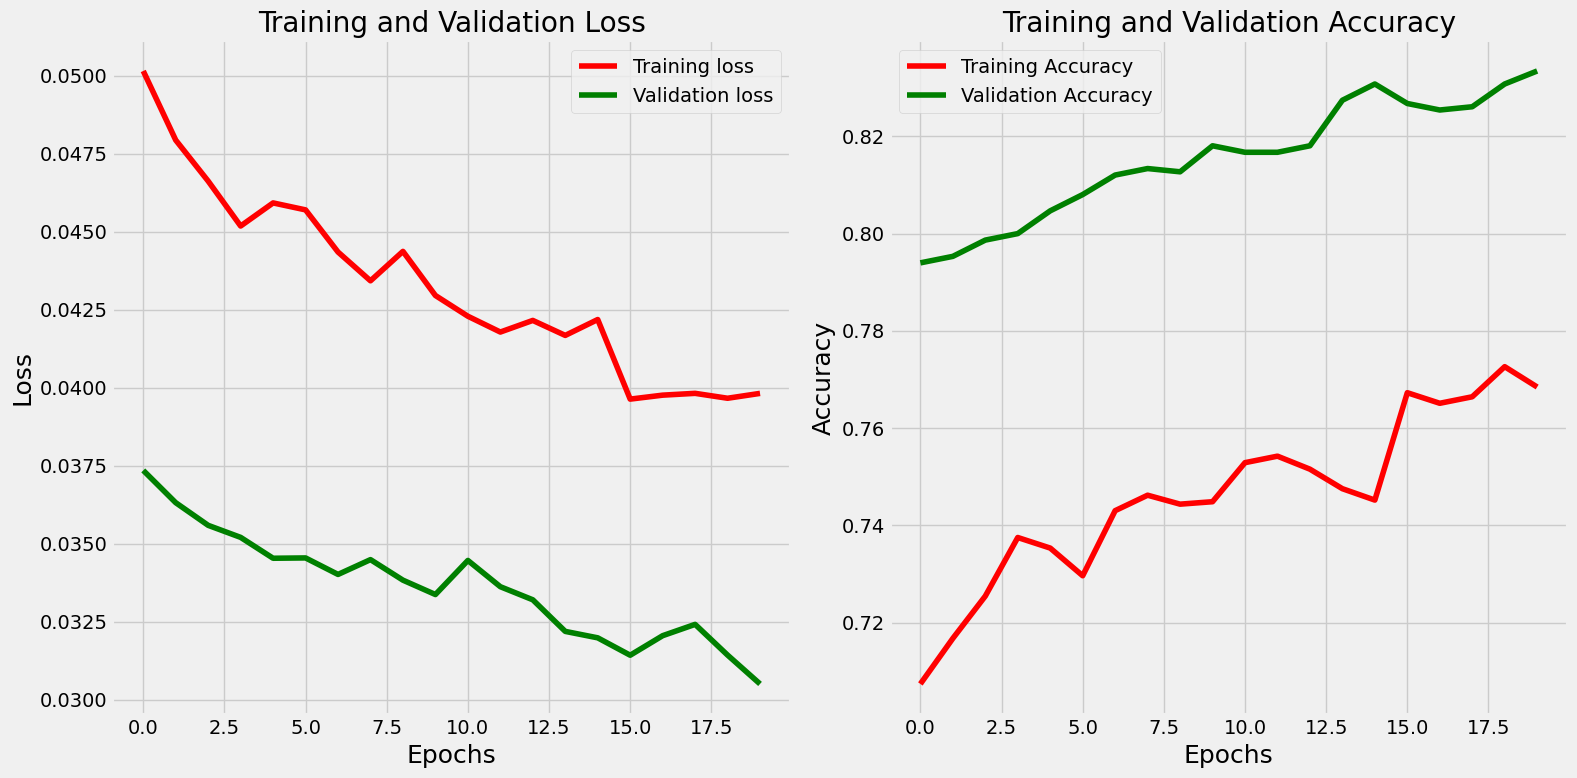

In [27]:
def plot_auc_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_Loss, 'r', label='Training loss')
    axes[0].plot(Epochs, val_Loss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, train_Acc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, val_Acc, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(epochs=20)

In [28]:
device

device(type='cuda')

there were 420 errors in 1495 tests for an accuracy of  71.91%


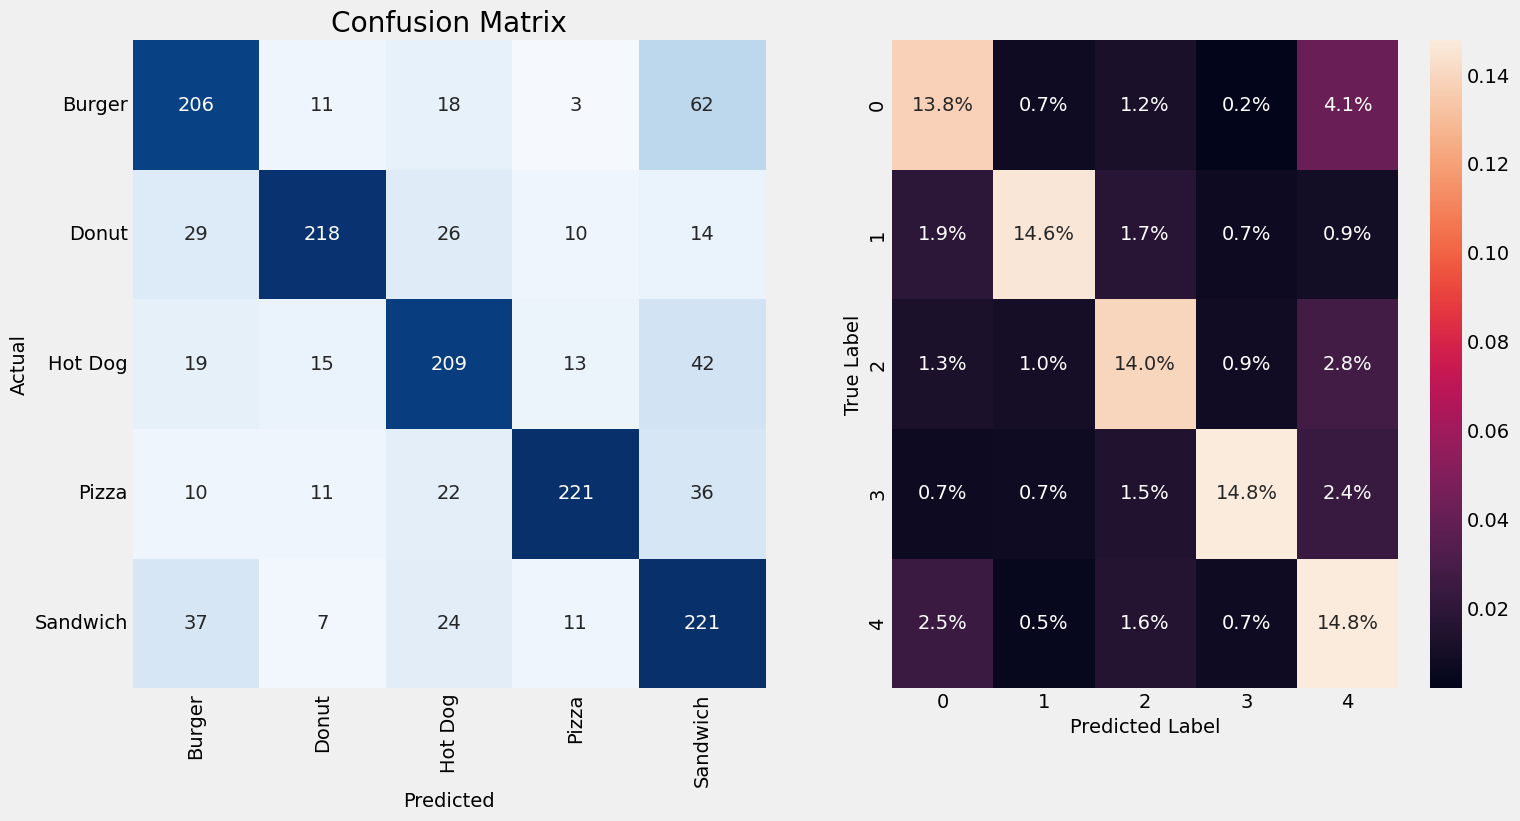

Classification Report:
----------------------
               precision    recall  f1-score   support

      Burger     0.6844    0.6867    0.6855       300
       Donut     0.8321    0.7340    0.7800       297
     Hot Dog     0.6990    0.7013    0.7002       298
       Pizza     0.8566    0.7367    0.7921       300
    Sandwich     0.5893    0.7367    0.6548       300

    accuracy                         0.7191      1495
   macro avg     0.7323    0.7191    0.7225      1495
weighted avg     0.7321    0.7191    0.7224      1495



In [29]:
try:
    json_file = open('./classes_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []
    net = DenseNetwork(num_classes=5).to(device)
    net_weight_path = './DenseNetwork.pth'
    net.load_state_dict(torch.load(net_weight_path))

    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            preds = torch.argmax(torch.softmax(net(images.to(device)), dim=0), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(validloader)

In [31]:
# Save Model
torch.save(net.state_dict(), "./modelv0.0.1.pt")

## Test Model

In [41]:
# Load the trained model
net.eval()
net.load_state_dict(torch.load("./modelv0.0.1.pt"))

# Define a function to predict the class of an image
def predict(image_path):
    # Load the image
    image = Image.open(image_path)

    # Preprocess the image
    transform = transforms.Compose([
        transforms.RandomResizedCrop(200),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = net(image)
        pred = torch.argmax(output, dim=1).item()

    # Get the class name
    class_names = ['burger', 'fries', 'hotdog', 'pizza', 'sandwich']
    predicted_class = class_names[pred]

    # Print the prediction
    print(f"Predicted class: {predicted_class}")

# Test the model with custom images
custom_images = [
    "./data/pizza1.jpeg",
    "./data/pizza2.jpg",
    "./data/burger1.jpeg",
    "./data/sandwich1.jpeg",
]

for image_path in custom_images:
    predict(image_path)


Predicted class: pizza
Predicted class: pizza
Predicted class: burger
Predicted class: sandwich
